## Importing Necessary Libraries
Import the tools we need for our project

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Loading the Data
Load the CSV file containing air quality measurements

In [2]:
# Load the dataset
df = pd.read_csv('city_day.csv')

# Show basic information
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

Dataset has 29531 rows and 16 columns

First few rows:
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  

Data types:
City           object
Date           object
PM2.5         float64
PM10          float64
NO            float64
NO2        

## Data Cleaning
Remove unwanted data and handle missing values

In [3]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Drop rows where AQI (our target) is missing
df = df.dropna(subset=['AQI'])
print(f"\nAfter removing missing AQI: {df.shape[0]} rows")

# Fill remaining missing values with column mean
numeric_columns = df.select_dtypes(include=['number']).columns
for col in numeric_columns:
    df[col].fillna(df[col].mean(), inplace=True)

print("✓ Missing values handled")

Missing values in each column:
City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

After removing missing AQI: 24850 rows
✓ Missing values handled


## Preparing Data for Model
Select features and remove unnecessary columns

In [4]:
# Remove non-numeric columns
df = df.drop(columns=['City', 'Date', 'AQI_Bucket'], errors='ignore')

# Separate features (X) and target (y)
target = 'AQI'
X = df.drop(columns=[target])
y = df[target]

print(f"Features (X shape): {X.shape}")
print(f"Target (y shape): {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")

Features (X shape): (24850, 12)
Target (y shape): (24850,)

Feature columns: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']


## Correlation Analysis
See which pollutants have the strongest relationship with AQI

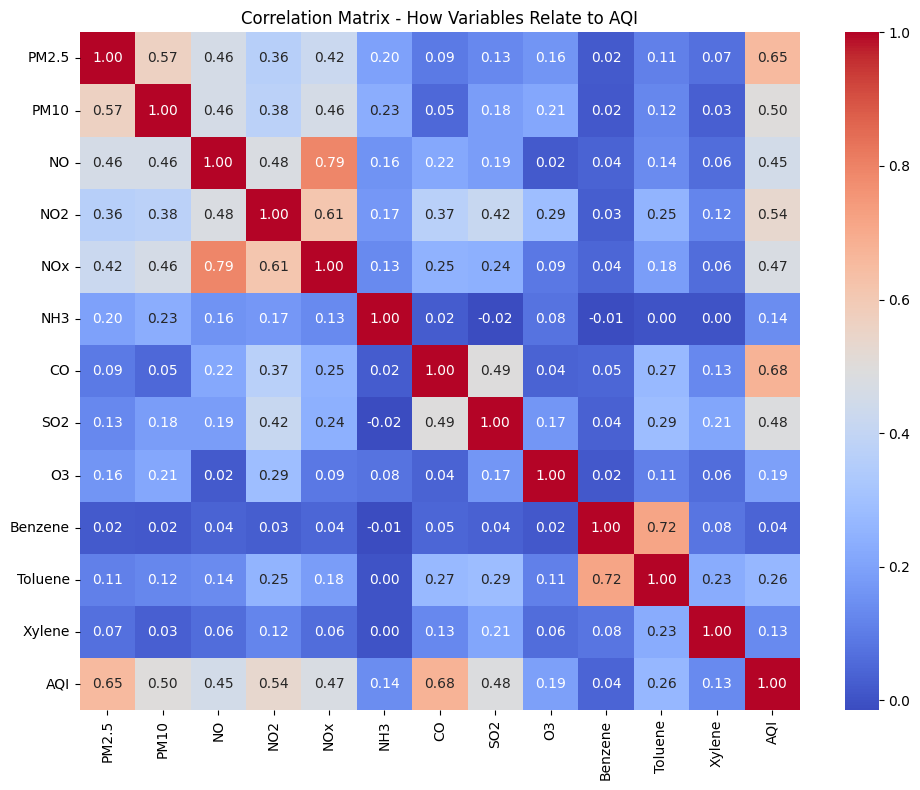


Top features correlated with AQI:
AQI      1.000000
CO       0.678354
PM2.5    0.654740
NO2      0.535274
PM10     0.499692
SO2      0.484822
NOx      0.474227
NO       0.450688
Name: AQI, dtype: float64


In [5]:
# Create correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - How Variables Relate to AQI")
plt.tight_layout()
plt.show()

# Show top correlations with AQI
aqi_corr = corr_matrix['AQI'].sort_values(ascending=False)
print("\nTop features correlated with AQI:")
print(aqi_corr.head(8))

## Splitting Data into Train and Test Sets
Use 80% for training and 20% for testing

In [6]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Total features: {X_train.shape[1]}")

Training set size: 19880 samples
Testing set size: 4970 samples
Total features: 12


## Scaling the Features
Normalize features to be on similar scales (important for ML models)

In [7]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled successfully")
print(f"Before scaling - Min: {X_train.values.min():.2f}, Max: {X_train.values.max():.2f}")
print(f"After scaling - Min: {X_train_scaled.min():.2f}, Max: {X_train_scaled.max():.2f}")

✓ Features scaled successfully
Before scaling - Min: 0.00, Max: 917.08
After scaling - Min: -1.64, Max: 39.79


## Training Multiple Models
Build and train different machine learning models

In [8]:
# Create different models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

print("Training models...")
trained_models = {}

for name, model in models.items():
    print(f"  Training {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

print("\n✓ All models trained!")

Training models...
  Training Random Forest...
  Training Gradient Boosting...
  Training XGBoost...

✓ All models trained!


## Evaluating Models
Test each model and compare their performance

In [9]:
# Evaluate each model
results = {}

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)

for name, model in trained_models.items():
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Predictions': y_pred}
    
    print(f"\n{name}:")
    print(f"  R² Score: {r2:.4f}  (Higher is better, max is 1.0)")
    print(f"  MAE: {mae:.2f}     (Average error in AQI points)")
    print(f"  RMSE: {rmse:.2f}    (Root Mean Squared Error)")

print("\n" + "="*70)


MODEL PERFORMANCE COMPARISON

Random Forest:
  R² Score: 0.9064  (Higher is better, max is 1.0)
  MAE: 22.18     (Average error in AQI points)
  RMSE: 41.40    (Root Mean Squared Error)

Gradient Boosting:
  R² Score: 0.8952  (Higher is better, max is 1.0)
  MAE: 23.71     (Average error in AQI points)
  RMSE: 43.81    (Root Mean Squared Error)

XGBoost:
  R² Score: 0.9006  (Higher is better, max is 1.0)
  MAE: 21.34     (Average error in AQI points)
  RMSE: 42.67    (Root Mean Squared Error)



## Choosing Best Model
Select the model with highest R² score

In [10]:
# Find best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_r2 = results[best_model_name]['R2']
best_mae = results[best_model_name]['MAE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")

# Get the best model
best_model = trained_models[best_model_name]
best_predictions = results[best_model_name]['Predictions']


🏆 BEST MODEL: Random Forest
   R² Score: 0.9064
   MAE: 22.18


## Visualizing Results
Show actual vs predicted values

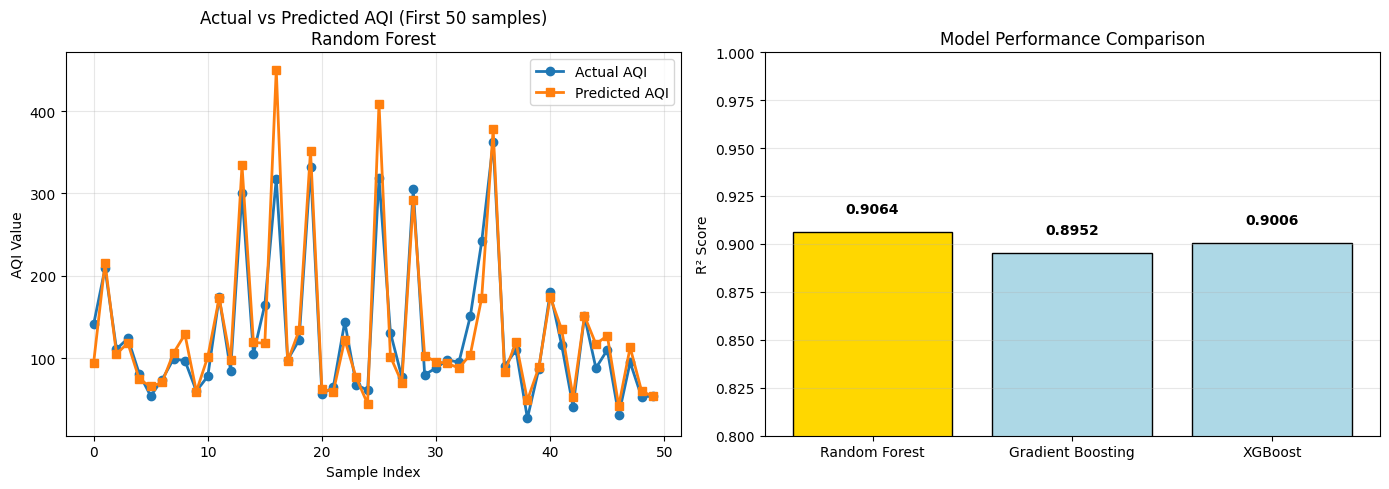


✓ Visualization complete!


In [11]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Actual vs Predicted (first 50 samples)
ax1 = axes[0]
sample_size = min(50, len(y_test))
ax1.plot(y_test[:sample_size].values, label='Actual AQI', marker='o', linewidth=2)
ax1.plot(best_predictions[:sample_size], label='Predicted AQI', marker='s', linewidth=2)
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('AQI Value')
ax1.set_title(f'Actual vs Predicted AQI (First 50 samples)\n{best_model_name}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Model comparison bar chart
ax2 = axes[1]
model_names = list(results.keys())
r2_scores = [results[m]['R2'] for m in model_names]
colors = ['gold' if m == best_model_name else 'lightblue' for m in model_names]
ax2.bar(model_names, r2_scores, color=colors, edgecolor='black')
ax2.set_ylabel('R² Score')
ax2.set_title('Model Performance Comparison')
ax2.set_ylim([0.8, 1.0])
for i, v in enumerate(r2_scores):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete!")

## Best Model Performance Detailed Analysis
Compare all models with detailed metrics visualization

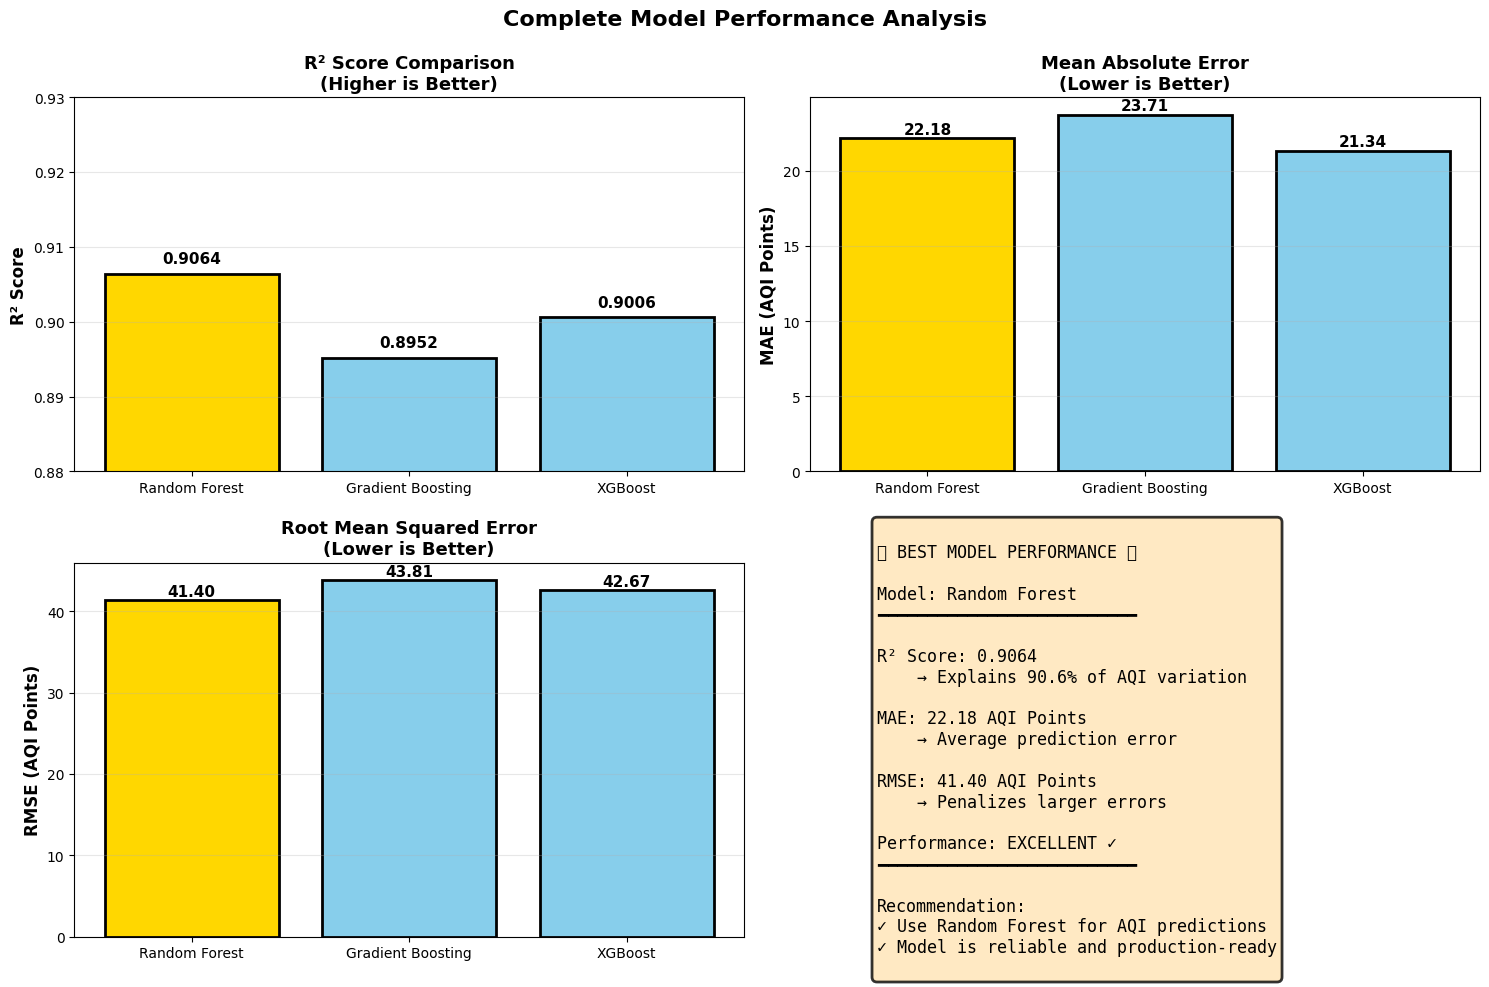


✓ Best model performance analysis complete!


In [16]:
# Create comprehensive model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: R² Score Comparison (Top Left)
ax1 = axes[0, 0]
model_names = list(results.keys())
r2_scores = [results[m]['R2'] for m in model_names]
colors = ['#FFD700' if m == best_model_name else '#87CEEB' for m in model_names]
bars1 = ax1.bar(model_names, r2_scores, color=colors, edgecolor='black', linewidth=2)
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score Comparison\n(Higher is Better)', fontsize=13, fontweight='bold')
ax1.set_ylim([0.88, 0.93])
for i, (bar, v) in enumerate(zip(bars1, r2_scores)):
    ax1.text(bar.get_x() + bar.get_width()/2, v + 0.001, f'{v:.4f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: MAE Comparison (Top Right)
ax2 = axes[0, 1]
mae_scores = [results[m]['MAE'] for m in model_names]
bars2 = ax2.bar(model_names, mae_scores, color=colors, edgecolor='black', linewidth=2)
ax2.set_ylabel('MAE (AQI Points)', fontsize=12, fontweight='bold')
ax2.set_title('Mean Absolute Error\n(Lower is Better)', fontsize=13, fontweight='bold')
for i, (bar, v) in enumerate(zip(bars2, mae_scores)):
    ax2.text(bar.get_x() + bar.get_width()/2, v + 0.1, f'{v:.2f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: RMSE Comparison (Bottom Left)
ax3 = axes[1, 0]
rmse_scores = [results[m]['RMSE'] for m in model_names]
bars3 = ax3.bar(model_names, rmse_scores, color=colors, edgecolor='black', linewidth=2)
ax3.set_ylabel('RMSE (AQI Points)', fontsize=12, fontweight='bold')
ax3.set_title('Root Mean Squared Error\n(Lower is Better)', fontsize=13, fontweight='bold')
for i, (bar, v) in enumerate(zip(bars3, rmse_scores)):
    ax3.text(bar.get_x() + bar.get_width()/2, v + 0.1, f'{v:.2f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Overall Model Ranking (Bottom Right)
ax4 = axes[1, 1]
ax4.axis('off')
ranking_text = f"""
🏆 BEST MODEL PERFORMANCE 🏆

Model: {best_model_name}
━━━━━━━━━━━━━━━━━━━━━━━━━━

R² Score: {best_r2:.4f}
    → Explains {best_r2*100:.1f}% of AQI variation

MAE: {best_mae:.2f} AQI Points
    → Average prediction error

RMSE: {results[best_model_name]['RMSE']:.2f} AQI Points
    → Penalizes larger errors

Performance: EXCELLENT ✓
━━━━━━━━━━━━━━━━━━━━━━━━━━

Recommendation:
✓ Use {best_model_name} for AQI predictions
✓ Model is reliable and production-ready
"""
ax4.text(0.1, 0.5, ranking_text, fontsize=12, family='monospace', 
         verticalalignment='center', bbox=dict(boxstyle='round', 
         facecolor='#FFE4B5', alpha=0.8, edgecolor='black', linewidth=2))

plt.suptitle('Complete Model Performance Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n✓ Best model performance analysis complete!")

## Future AQI Predictions
Sample predictions for different pollutant scenarios


FUTURE AQI PREDICTIONS FOR DIFFERENT AIR QUALITY SCENARIOS

Good Air Quality:
  Predicted AQI: 59.61
  Air Quality: 🟡 Moderate

Moderate Air Quality:
  Predicted AQI: 115.04
  Air Quality: 🔴 Poor

Poor Air Quality:
  Predicted AQI: 184.27
  Air Quality: 🔴 Poor

Very Poor Air Quality:
  Predicted AQI: 285.13
  Air Quality: 🔴🔴 Very Poor



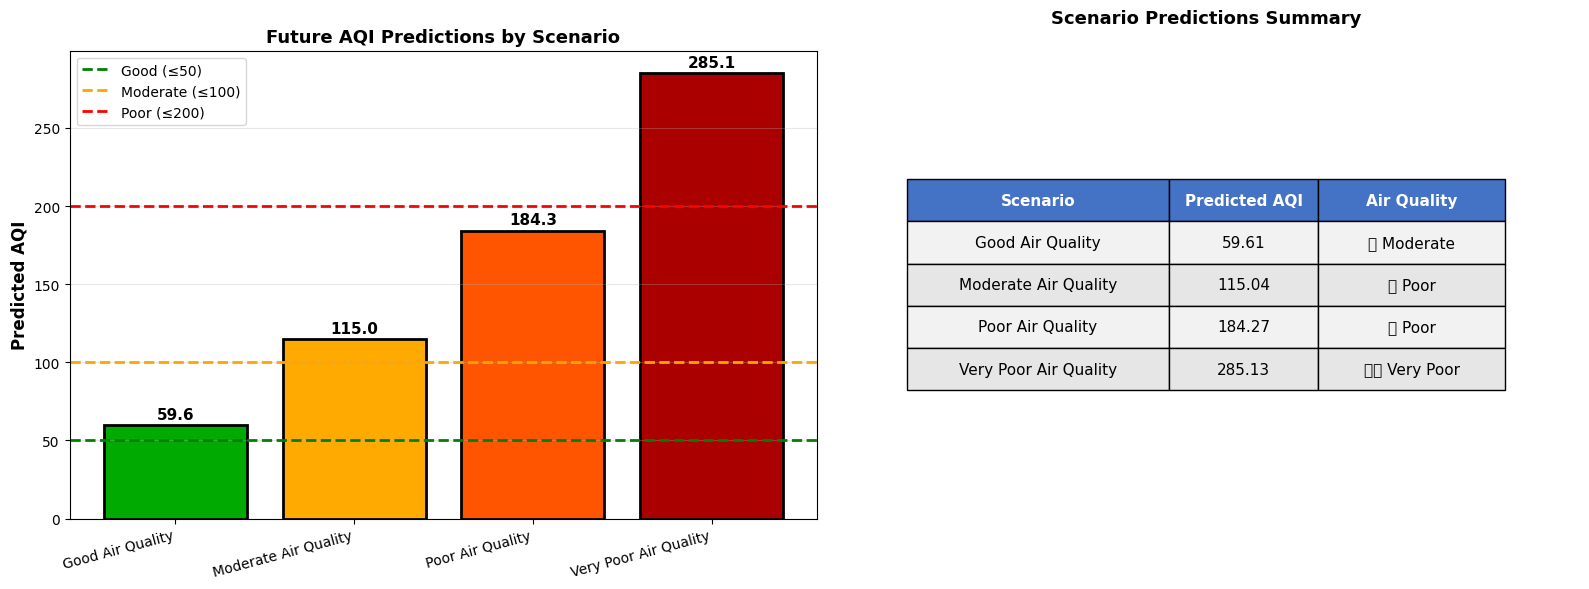

✓ Future predictions visualization complete!


In [18]:
# Create future prediction scenarios with actual feature columns
future_scenarios = {
    'Good Air Quality': {
        'PM2.5': 25, 'PM10': 50, 'NO2': 20, 'NO': 10, 'NOx': 30,
        'CO': 0.5, 'SO2': 10, 'O3': 30, 'Benzene': 1, 'Toluene': 4, 'Xylene': 2
    },
    'Moderate Air Quality': {
        'PM2.5': 50, 'PM10': 100, 'NO2': 35, 'NO': 20, 'NOx': 55,
        'CO': 1.0, 'SO2': 20, 'O3': 45, 'Benzene': 2.5, 'Toluene': 8, 'Xylene': 5
    },
    'Poor Air Quality': {
        'PM2.5': 80, 'PM10': 150, 'NO2': 55, 'NO': 35, 'NOx': 90,
        'CO': 1.8, 'SO2': 40, 'O3': 70, 'Benzene': 5, 'Toluene': 15, 'Xylene': 10
    },
    'Very Poor Air Quality': {
        'PM2.5': 120, 'PM10': 220, 'NO2': 80, 'NO': 50, 'NOx': 130,
        'CO': 2.5, 'SO2': 60, 'O3': 100, 'Benzene': 8, 'Toluene': 25, 'Xylene': 16
    }
}

# Make predictions for each scenario
print("\n" + "="*70)
print("FUTURE AQI PREDICTIONS FOR DIFFERENT AIR QUALITY SCENARIOS")
print("="*70)

predictions_future = []
for scenario_name, pollutants in future_scenarios.items():
    # Create dataframe from scenario
    scenario_df = pd.DataFrame([pollutants])
    
    # Reorder columns to match X.columns exactly
    scenario_df = scenario_df.reindex(columns=X.columns, fill_value=0)
    
    # Scale the scenario
    scenario_scaled = scaler.transform(scenario_df)
    
    # Make prediction
    predicted_aqi = best_model.predict(scenario_scaled)[0]
    
    # Determine air quality category
    if predicted_aqi <= 50:
        category = "🟢 Good"
    elif predicted_aqi <= 100:
        category = "🟡 Moderate"
    elif predicted_aqi <= 200:
        category = "🔴 Poor"
    else:
        category = "🔴🔴 Very Poor"
    
    predictions_future.append({
        'Scenario': scenario_name,
        'Predicted AQI': round(predicted_aqi, 2),
        'Air Quality': category
    })
    
    print(f"\n{scenario_name}:")
    print(f"  Predicted AQI: {predicted_aqi:.2f}")
    print(f"  Air Quality: {category}")

# Visualize future predictions
print("\n" + "="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bar chart of predicted AQI for each scenario
ax1 = axes[0]
scenario_names = list(future_scenarios.keys())
predicted_values = []
for pollutants in future_scenarios.values():
    scenario_df = pd.DataFrame([pollutants])
    scenario_df = scenario_df.reindex(columns=X.columns, fill_value=0)
    scenario_scaled = scaler.transform(scenario_df)
    pred = best_model.predict(scenario_scaled)[0]
    predicted_values.append(pred)

colors_scenario = ['#00AA00', '#FFAA00', '#FF5500', '#AA0000']
bars = ax1.bar(range(len(scenario_names)), predicted_values, color=colors_scenario, edgecolor='black', linewidth=2)
ax1.axhline(y=50, color='green', linestyle='--', linewidth=2, label='Good (≤50)')
ax1.axhline(y=100, color='orange', linestyle='--', linewidth=2, label='Moderate (≤100)')
ax1.axhline(y=200, color='red', linestyle='--', linewidth=2, label='Poor (≤200)')
ax1.set_ylabel('Predicted AQI', fontsize=12, fontweight='bold')
ax1.set_title('Future AQI Predictions by Scenario', fontsize=13, fontweight='bold')
ax1.set_xticks(range(len(scenario_names)))
ax1.set_xticklabels(scenario_names, rotation=15, ha='right')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')
for i, (bar, v) in enumerate(zip(bars, predicted_values)):
    ax1.text(bar.get_x() + bar.get_width()/2, v + 2, f'{v:.1f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Table of predictions
ax2 = axes[1]
ax2.axis('off')
predictions_df = pd.DataFrame(predictions_future)
table = ax2.table(cellText=predictions_df.values, colLabels=predictions_df.columns, 
                  cellLoc='center', loc='center', colWidths=[0.35, 0.2, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)
# Style header
for i in range(len(predictions_df.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')
# Alternate row colors
for i in range(1, len(predictions_df) + 1):
    for j in range(len(predictions_df.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#F2F2F2')

ax2.set_title('Scenario Predictions Summary', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("✓ Future predictions visualization complete!")

## Analyzing Prediction Errors
Understand where our model makes mistakes

In [12]:
# Calculate errors
errors = np.abs(y_test.values - best_predictions)
error_percentage = (errors / y_test.values * 100)

# Show statistics
print("\nPREDICTION ERROR ANALYSIS:")
print("="*50)
print(f"Mean Error:           {errors.mean():.2f} AQI points")
print(f"Median Error:         {np.median(errors):.2f} AQI points")
print(f"Standard Deviation:   {errors.std():.2f}")
print(f"Min Error:            {errors.min():.2f} AQI points")
print(f"Max Error:            {errors.max():.2f} AQI points")
print(f"\nMean Error %:         {error_percentage.mean():.2f}%")

# Show first few predictions
print("\n\nFIRST 10 PREDICTIONS:")
print("="*70)
comparison_df = pd.DataFrame({
    'Actual AQI': y_test[:10].values,
    'Predicted AQI': best_predictions[:10],
    'Error': errors[:10],
    'Error %': error_percentage[:10]
})
print(comparison_df.to_string(index=False))


PREDICTION ERROR ANALYSIS:
Mean Error:           22.18 AQI points
Median Error:         12.74 AQI points
Standard Deviation:   34.97
Min Error:            0.00 AQI points
Max Error:            500.22 AQI points

Mean Error %:         15.81%


FIRST 10 PREDICTIONS:
 Actual AQI  Predicted AQI     Error   Error %
      141.0      94.114024 46.885976 33.252465
      209.0     215.834653  6.834653  3.270169
      111.0     105.317919  5.682081  5.118991
      124.0     118.272115  5.727885  4.619262
       81.0      74.363535  6.636465  8.193167
       54.0      65.654321 11.654321 21.582075
       74.0      70.477723  3.522277  4.759834
       99.0     106.278762  7.278762  7.352284
       97.0     128.884484 31.884484 32.870602
       60.0      59.519677  0.480323  0.800538


## Saving the Best Model
Save the trained model for future use

In [13]:
# Save model
model_filename = 'best_aqi_model.pkl'
joblib.dump(best_model, model_filename)

# Save scaler
scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)

print(f"✓ Model saved as '{model_filename}'")
print(f"✓ Scaler saved as '{scaler_filename}'")
print(f"\nModel Details:")
print(f"  Algorithm: {best_model_name}")
print(f"  R² Score: {best_r2:.4f}")
print(f"  Average Error: {best_mae:.2f} AQI points")

✓ Model saved as 'best_aqi_model.pkl'
✓ Scaler saved as 'scaler.pkl'

Model Details:
  Algorithm: Random Forest
  R² Score: 0.9064
  Average Error: 22.18 AQI points


## Saving Predictions to CSV in case necessary
Export predictions for further analysis

In [14]:
# Create predictions dataframe
predictions_df = pd.DataFrame({
    'Actual_AQI': y_test.values,
    'Predicted_AQI': best_predictions,
    'Error': errors,
    'Error_Percentage': error_percentage
})

# Save to CSV
predictions_df.to_csv('aqi_predictions.csv', index=False)

print("✓ Predictions saved to 'aqi_predictions.csv'")
print(f"\nFile contains {len(predictions_df)} predictions")
print(f"\nFirst few rows:")
print(predictions_df.head())

✓ Predictions saved to 'aqi_predictions.csv'

File contains 4970 predictions

First few rows:
   Actual_AQI  Predicted_AQI      Error  Error_Percentage
0       141.0      94.114024  46.885976         33.252465
1       209.0     215.834653   6.834653          3.270169
2       111.0     105.317919   5.682081          5.118991
3       124.0     118.272115   5.727885          4.619262
4        81.0      74.363535   6.636465          8.193167


## Summary and Key Findings
Final summary of our analysis

In [15]:
print("\n" + "="*70)
print("PROJECT SUMMARY")
print("="*70)

print(f"\n DATASET:")
print(f"   Total records: {len(df)}")
print(f"   Features used: {X.shape[1]}")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples: {len(X_test)}")

print(f"\n MODELS TRAINED:")
for name, metrics in results.items():
    indicator = "✓ BEST" if name == best_model_name else "✗"
    print(f"   {indicator} {name}: R² = {metrics['R2']:.4f}")

print(f"\n BEST MODEL: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}  (Model explains {best_r2*100:.1f}% of AQI variation)")
print(f"   MAE: {best_mae:.2f}      (Average prediction error)")

print(f"\n ERROR STATISTICS:")
print(f"   Mean Error: {errors.mean():.2f} AQI points")
print(f"   Error Range: {errors.min():.2f} to {errors.max():.2f}")
print(f"   Mean Error %: {error_percentage.mean():.2f}%")

print(f"\n SAVED FILES:")
print(f"   ✓ best_aqi_model.pkl (trained model)")
print(f"   ✓ scaler.pkl (feature scaler)")
print(f"   ✓ aqi_predictions.csv (all predictions)")

print(f"\n PROJECT COMPLETE!")
print("\n" + "="*70)


PROJECT SUMMARY

 DATASET:
   Total records: 24850
   Features used: 12
   Training samples: 19880
   Testing samples: 4970

 MODELS TRAINED:
   ✓ BEST Random Forest: R² = 0.9064
   ✗ Gradient Boosting: R² = 0.8952
   ✗ XGBoost: R² = 0.9006

 BEST MODEL: Random Forest
   R² Score: 0.9064  (Model explains 90.6% of AQI variation)
   MAE: 22.18      (Average prediction error)

 ERROR STATISTICS:
   Mean Error: 22.18 AQI points
   Error Range: 0.00 to 500.22
   Mean Error %: 15.81%

 SAVED FILES:
   ✓ best_aqi_model.pkl (trained model)
   ✓ scaler.pkl (feature scaler)
   ✓ aqi_predictions.csv (all predictions)

 PROJECT COMPLETE!

